Using a deep neural network for reinforcement learning. Deep Q network used to solve the lunar lander task. Completed March 2021 by Colleen Gillon

# **Deep Q-learning in OpenAI Gym - LunarLander-v2**

**TASK:** Land lander on landing pad at coord (0, 0).

**STATE VECTOR:** 
  0. x_position
  1. y_position
  2. x_velocity
  3. y_velocity
  4. lander_angle
  5. angular_velocity
  6. left_contact_point
  7. right_contact_point

**ACTIONS (4):**
  0. Do nothing
  1. Fire left orientation engine
  2. Fire main engine
  3. Fire right orientation engine

**REWARDS:**
  - Moving toward landing pad
  - Ground contact (anywhere), per leg: +10
  - Coming to a rest: +100

**PENALTIES:**
  - Moving away from landing pad or loss of ground contact
  - Firing main engine: -0.3 per frame
  - Crashing: -100

**NOTES:**
  - Episode terminates if lander crashes, comes to a rest on the landing pad or 1000 steps are completed.
  - Landing outside landing pad is possible, but does not terminate the episode.
  - Fuel is infinite, so an agent can learn to fly and then land on its first attempt.
  - An episode is deemed successful if a score of 200 is obtained.
  - The environment is deemed solved if 100 consecutive episodes succeed.

**RESOURCES:**
- [YouTube tutorial](https://www.youtube.com/watch?v=wc-FxNENg9U)
- [YouTube tutorial module](https://github.com/philtabor/Youtube-Code-Repository/blob/master/ReinforcementLearning/DeepQLearning/simple_dqn_torch_2020.py)
- [YouTube tutorial main](https://github.com/philtabor/Youtube-Code-Repository/blob/master/ReinforcementLearning/DeepQLearning/main_torch_dqn_lunar_lander_2020.py)
- [OpenAI Gym documentation](https://gym.openai.com/envs/LunarLander-v2/)
- [OpenAI Gym code](https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py)

## **Install pre-requisites**

### **Install OpenAI Gym packages**

In [ ]:
!pip install box2d-py
!pip install gym[Box_2D]

     |████████████████████████████████| 450kB 22.3MB/s 


### **Install packages needed to render (visualize) environment**

In [ ]:
!apt-get install python-opengl -y
!apt install xvfb -y
!apt install imagemagick

!pip install pyvirtualdisplay
!pip install piglet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 1s (858 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 160975 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 784 kB of 

### **Install packages for TPU use, if applicable**

**Note:** TPU use is not recommended, as the notebook tends to crash after a few episodes. Code likely not well adapted.

In [ ]:
import os
TPU_AVAIL = "COLAB_TPU_ADDR" in os.environ.keys()
if TPU_AVAIL:
    # wheel for python 3.7, pytorch 1.7
    !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp37-cp37m-linux_x86_64.whl --quiet
    # VERSION = "nightly"  #@param ["1.5" , "20200325", "nightly"]
    # !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
    # !python pytorch-xla-env-setup.py --version $VERSION

## **Set up virtual display**
Adapted from [this Colab notebook](https://colab.research.google.com/drive/1tug_bpg8RwrFOI8C6Ed-zo0OgD3yfnWy#scrollTo=AutUqpSRYN1W), with patch adapted from [this GitLab repo](https://gitlab.com/ymd_h/gym-notebook-wrapper/-/blob/master/gnwrapper/__init__.py) to prevent display from crashing after a CTRL-C event.

In [ ]:
import subprocess
from unittest.mock import patch

def start_display_with_patch(display):
    original = subprocess.Popen
    def Popen(cmd, pass_fds, stdout, stderr, shell):
        return original(
            cmd, pass_fds=pass_fds, stdout=stdout, stderr=stderr,
            shell=shell, preexec_fn=os.setpgrp)

    with patch("subprocess.Popen", Popen):
        display.start()

In [ ]:
from pyvirtualdisplay import Display

USE_NOTEBOOK_PATCH = True # use Ctrl-C patch, if running in a notebook

display = Display(visible=0, size=(1400, 900))
if USE_NOTEBOOK_PATCH:
    start_display_with_patch(display)
else:
    display.start() 

import os
if not isinstance(os.environ.get("DISPLAY"), str) or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    %env DISPLAY=:1

## **Import modules**

In [ ]:
import random

import torch as T
import torch.nn as nn # to handle layers
import torch.nn.functional as F # for activation function
import torch.optim as optim # for optimizer
# for TPU use
if TPU_AVAIL:
    import torch_xla
    import torch_xla.core.xla_model as xm

import gym
from gym import wrappers
import numpy as np
import matplotlib.pyplot as plt

## **Set some parameters and define a few helper functions**

### **Set some pyplot plotting parameters**

In [ ]:
params = {"axes.labelsize"       : "x-large", # xx-large axis labels
          "axes.linewidth"       : 1.5,        # thicker axis lines
          "axes.spines.right"    : False,      # no axis spine on right
          "axes.spines.top"      : False,      # no axis spine at top
          "axes.titlesize"       : "x-large",  # x-large axis title
          "errorbar.capsize"     : 4,          # errorbar cap length
          "figure.titlesize"     : "x-large",  # x-large figure title
          "figure.autolayout"    : True,       # adjusts layout
          "font.size"            : 12,         # basic font size value
          "legend.fontsize"      : "x-large",  # x-large legend text
          "lines.dashed_pattern" : [8.0, 4.0], # longer dashes
          "lines.linewidth"      : 2.5,        # thicker lines
          "lines.markeredgewidth": 2.5,        # thick marker edge widths 
                                                # (e.g., cap thickness) 
          "lines.markersize"     : 10,         # bigger markers
          "patch.linewidth"      : 2.5,        # thicker lines for patches
          "savefig.format"       : "svg",      # figure save format
          "savefig.bbox"         : "tight",    # tight cropping of figure
          "xtick.labelsize"      : "x-large",  # x-large x-tick labels
          "xtick.major.size"     : 8.0,        # longer x-ticks
          "xtick.major.width"    : 2.0,        # thicker x-ticks
          "ytick.labelsize"      : "x-large",  # x-large y-tick labels
          "ytick.major.size"     : 8.0,        # longer y-ticks
          "ytick.major.width"    : 2.0,        # thicker y-ticks
          }

plt.rcParams.update(params)

### **Define a wrapper for timing functions**

In [ ]:
import time
def time_it(func):
    def wrapper_time_it(*args, **kwargs):
        start = time.time()
        output = func(*args, **kwargs)
        end = time.time()
        duration = end - start
        # only works up to 24h
        ms = repr(duration).split('.')[1][:3]
        time_format = time.strftime("%H:%M:%S.{}".format(ms), time.gmtime(duration))
        print(f"Time: {time_format}")
        return output 
    return wrapper_time_it

### **Define a seeding function**
Seeds GPU or TPU, if available.

In [ ]:
def seed_all(seed, env):
    if seed in [None, -1]:
        seed = random.randint(1, 10000)
        print(f"Random seed: {seed}")
    else:
        print(f"Preset seed: {seed}")
    
    random.seed(seed)
    np.random.seed(seed)
    T.manual_seed(seed)
    if TPU_AVAIL:
        xm.set_rng_state(seed)
    elif T.cuda.is_available():
        T.cuda.manual_seed_all(seed)
    
    env.seed(seed)

    return seed

### **Define a function to save recorded frames as a gif**
Adapted from [this script](https://www.floydhub.com/explore/templates/reinforcement-learning/gym-retro).

In [ ]:
from matplotlib import animation
def save_frames_as_gif(frames, filename=None):
    """
    Save a list of frames as a gif
    """
    patch = plt.imshow(frames[0])
    plt.axis("off")
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=30)
    if filename:
        if filename[-4:] != ".gif":
            filename = f"{filename}.gif"
        _ = anim.save(filename, dpi=72, writer="imagemagick")

### **Define a function to plot agent performance across episodes**

In [ ]:
def plot_learning(n_episodes, scores, eps_history, iters, successes, replace_target):
    n = int(n_episodes / 10)
    ep_iters = np.diff(np.insert(iters, 0, 0))

    plot_items = [scores, successes, ep_iters, eps_history]
    plot_names = ["Score", "Success", "Episode iterations", "Epsilon"]
    plot_rolling = [True, True, True, False]

    n_plots = len(plot_items)
    fig, ax = plt.subplots(n_plots, 1, sharex=True, figsize=[8, n_plots * 3])
    fig.suptitle(f"Episode stats (target network replaced every {replace_target} iterations)", y=1.05)

    for subax, item, name, rolling in zip(ax, plot_items, plot_names, plot_rolling):
        subax.plot(item, alpha=0.4)
        if rolling:
            rolling_item = np.convolve(item, np.ones(n)/n, mode='same')
            subax.plot(rolling_item, alpha=0.8)
        subax.set_title(name)

    subax.set_xlabel("Episodes")

## **Define the Deep Q-learning network**

In [ ]:
class DQN(nn.Module):
    def __init__(self,input_dims, fc1_dims, fc2_dims, n_actions, lr):
        super(DQN, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims   = fc1_dims
        self.fc2_dims   = fc2_dims
        self.output_dims= n_actions

        self.fc1  = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2  = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3  = nn.Linear(self.fc2_dims, self.output_dims)

        self.lr         = lr
        self.optimizer  = optim.Adam(self.parameters(), lr=self.lr)
        self.loss       = nn.MSELoss()
        if TPU_AVAIL:
            self.device = xm.xla_device()
        else:
            self.device = T.device("cuda:0" if T.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self,state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)

        return actions

## **The woes of the python equal sign**

In [ ]:
print("'=' will point when dealing with lists, dicts")
hat = [1, 2, 3]
cat = hat
cat[0] = 235
print(hat)
print(cat)

print("With simple structures like ints, '=' will copy")
hat = 25
cat = hat
cat = 2
print(hat, cat)

import copy
print("If you need to be totally sure you are copying, use a copy function, and then CHECK!!!")
hat = [1, 2, 3]
cat = hat.copy()
cat[0] = 235
print(hat)
print(cat)

'=' will point when dealing with lists, dicts
[235, 2, 3]
[235, 2, 3]
With simple structures like ints, '=' will copy
25 2
If you need to be totally sure you are copying, use a copy function, and then CHECK!!!
[1, 2, 3]
[235, 2, 3]


## **Define the Agent**

In [ ]:
class DQ_agent(object):
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=100000, eps_end=0.01, eps_decay=1e-4, 
                 replace_target=0):
        self.gamma   = gamma
        self.set_epsilon(epsilon)
        self.eps_min = eps_end
        self.eps_dec = eps_decay
        self.lr      = lr
        self.action_space = [i for i in range(n_actions)]
        
        self.mem_size     = max_mem_size
        self.batch_size   = batch_size
        self.mem_cntr     = 0
        self.iter_cntr = 0
        self.replace_target = replace_target

        self.Q_eval = DQN(input_dims, n_actions=n_actions, fc1_dims=FC1_DIMS, 
                          fc2_dims=FC2_DIMS, lr=self.lr)
        if self.replace_target == 0:
            self.Q_next = self.Q_eval
        else:
            self.Q_next = DQN(input_dims, n_actions=n_actions, 
                              fc1_dims=FC1_DIMS, fc2_dims=FC2_DIMS, lr=self.lr)
            self.Q_next.load_state_dict(self.Q_eval.state_dict())

        # memory buffers
        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory    = np.zeros(self.mem_size, dtype=np.float32)
        self.reward_memory    = np.zeros(self.mem_size, dtype=np.float32)

        # value of terminal state is always 0, so there are no future rewards 
        # to attain
        self.terminal_memory  = np.zeros(self.mem_size, dtype=np.bool)


    def store_transition(self, state, action, reward, next_state, done):
        # wrap around and rewrite earliest memories after memory is full
        index = self.mem_cntr % self.mem_size
        self.state_memory[index]     = state
        self.action_memory[index]    = action
        self.reward_memory[index]    = reward
        self.new_state_memory[index] = next_state
        self.terminal_memory[index]  = done

        self.mem_cntr += 1

    def choose_action(self,observation):
      # epsilon greedy action selection 
        if np.random.random() > self.epsilon:
            # take best action (square brackets makes it a batch of size 1)
            state = T.tensor([observation]).to(self.Q_eval.device)
            actions = self.Q_eval(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action
    
    def set_epsilon(self, epsilon):
        if not (0 <= epsilon <= 1.0):
            raise ValueError("Epsilon must be between 0 and 1.")
        if not hasattr(self, "epsilon"):
            self.epsilon = epsilon
        else:
            if epsilon > self.eps_min:
                self.epsilon = epsilon
            else:
                self.epsilon = self.eps_min

    def learn(self):
        if self.mem_cntr < self.batch_size:
            # don't bother learning if you don't have enough examples in memory
            return
        else:
            self.Q_eval.optimizer.zero_grad()
            max_mem = min(self.mem_size, self.mem_cntr)
            # sample from memory without replacement
            batch = np.random.choice(max_mem, self.batch_size, replace=False)
            batch_index = np.arange(self.batch_size, dtype=np.int32)

            batch_state     = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
            batch_new_state = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
            batch_reward    = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
            batch_terminal  = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)
            # batch_action doesn't need to be torch tensor
            batch_action    = self.action_memory[batch]

            q_eval = self.Q_eval(batch_state)[batch_index, batch_action]
            q_next = self.Q_next(batch_new_state).detach()
            q_next[batch_terminal] = 0.0

            # max along action dimension (retain 0th val since max returns 
            # [value, index], and we just want value)
            q_target = batch_reward + self.gamma * T.max(q_next, dim=1)[0] 

            loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
            loss.backward() # backprop the error 
            self.Q_eval.optimizer.step() # weight update

            # now decrease epsilon value
            self.set_epsilon(self.epsilon - self.eps_dec)

            self.iter_cntr += 1
            if (self.replace_target != 0) and (self.iter_cntr % self.replace_target == 0):
                self.Q_next.load_state_dict(self.Q_eval.state_dict())

## **Define function to run episodes**

In [ ]:
@time_it
def run_episodes(n_episodes=100, replace_target=0, verbose=True, seed=None):
    env = gym.make(GYM_ENV)
    seed_all(seed, env)
    
    if RENDER_EVERY:
        env = wrappers.Monitor(env, f"/tmp/{GYM_ENV}", force=True)
    
    n_actions = env.action_space.n
    n_observations = np.product(env.observation_space.shape) # flat
    
    # initialize agent
    agent = DQ_agent(
        gamma=GAMMA, 
        epsilon=EPS_START,
        eps_decay=EPS_DECAY,
        eps_end=EPS_END, 
        batch_size=BATCH_SIZE, 
        n_actions=env.action_space.n,
        input_dims=[n_observations], 
        lr=LR, 
        replace_target=replace_target)
    
    scores, avg_scores, eps_history, iters, successes = [], [], [], [], []
    consec_success = 0
    for i in range(n_episodes):
        score = 0
        done  = False
        observation = env.reset()

        if RENDER_EVERY:
            render = (not i % RENDER_EVERY)
        else:
            render = False

        if i != 0 and BOOST_EPS and not (i % BOOST_EPS):
          new_eps = EPS_START * 0.75 ** (i // BOOST_EPS)
          agent.set_epsilon(new_eps)

        if render:
          frames = []
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, __ = env.step(action)
            if render:
                frames.append(env.render(mode="rgb_array")) # collecting observation
            score += reward
            agent.store_transition(observation, action, reward, observation_, done)
            agent.learn()
            observation = observation_

        iter_n = agent.iter_cntr
        n_iter = iter_n if i == 0 else iter_n - iters[-1]
        
        scores.append(score)
        eps_history.append(agent.epsilon)
        iters.append(iter_n)

        avg_score = np.mean(scores[-int(n_episodes / AVG_SCORE):])
        avg_scores.append(avg_score)

        success = (score >= SUCCESS_SCORE)
        successes.append(success)

        if render:
            filename = (f"ep{i}_iter{iter_n}_sc{int(score)}_{int(success)}_"
                f"eps{agent.epsilon:.4f}_reptarg{replace_target}"
                ).replace(".", "-")
            save_frames_as_gif(frames, filename)

        if verbose or not i % PRINT_EVERY:
            print(
                f"episode: {i:>4}    "
                f"score: {score:>9.4f}    "
                f"avg: {avg_score:>9.4f}    "
                f"iters: {iter_n:>6} "
                "{:<7}    ".format(f"(+{n_iter})"),
                f"epsilon: {agent.epsilon:>6.4f}    ",
                f"success: {success}"
                )            
      
        if success:
          consec_success += 1
        else:
          consec_success = 0

        if consec_success >= SOLVED_N:
            print(f"Environment solved in {i} episodes.")
            break
      

    if RENDER_EVERY:
        env.close()

    return scores, avg_scores, eps_history, iters, successes

## **Some hardware stats**
*Rendering gifs tends to explain longer run times.*

**CPU:** 
- 100 episodes: 7 mins

**GPU:**
- 100 episodes: 3-5 mins
- 1000 episodes: 30-55 mins

**TPU**
- 100 episodes: 4 mins
- May be incompatible with the cell magic `%%timeit`, as it consistently crashes after ~8 episodes. 
- Notably, crashes also happen, though less consistently (?), even without `%%timeit`, suggesting a broader code/TPU compatibility problem.
- Crash log: `Computation requires more parameters (xxxx) than supported (limit 3307).[[{{node XRTCompile}}]]`
- Unclear what is causing the crash. Note that number of parameters cited in crash report appears unrelated to the number of model parameters or replay memory length.

## **Define global variables**

In [ ]:
# ENVIRONMENT PARAMETERS
GYM_ENV = "LunarLander-v2"
SUCCESS_SCORE = 200 # for LunarLander-v2
SOLVED_N = 100 # for LunarLander-v2

# MODEL/AGENT PARAMETERS
EPS_START = 1.0
EPS_DECAY = 5e-4
EPS_END = 0.01
BOOST_EPS = 500 # None for no epsilon boosting
BATCH_SIZE = 64
GAMMA = 0.99
LR = 0.003
FC1_DIMS = 256
FC2_DIMS = 256

N_EPISODES = 1000
REPLACE_TARGET = 0 # nbr of iterations after which to update target model

# LOGGING/VISUALIZATION PARAMETERS
AVG_SCORE = 10 # nbr of episodes to average over
PRINT_EVERY = 50 # if not verbose
RENDER_EVERY = 75 # 0 for never

## **Run the episodes**

Preset seed: 3412
episode:    0    score: -121.6306    avg: -121.6306    iters:      4 (+4)        epsilon: 0.9980     success: False
episode:   50    score: -460.8783    avg: -418.2340    iters:  10177 (+124)      epsilon: 0.0100     success: False
episode:  100    score: -631.3133    avg: -425.8219    iters:  20833 (+455)      epsilon: 0.0100     success: False
episode:  150    score: -708.9229    avg: -550.9710    iters:  36609 (+166)      epsilon: 0.0100     success: False
episode:  200    score: -524.4987    avg: -852.0378    iters:  52251 (+101)      epsilon: 0.0100     success: False
episode:  250    score: -795.7648    avg: -977.7138    iters:  63044 (+123)      epsilon: 0.0100     success: False
episode:  300    score: -1038.9123    avg: -1027.9242    iters:  75298 (+192)      epsilon: 0.0100     success: False
episode:  350    score: -4344.8240    avg: -1156.8264    iters:  94131 (+390)      epsilon: 0.0100     success: False
episode:  400    score: -526.1054    avg: -964.473

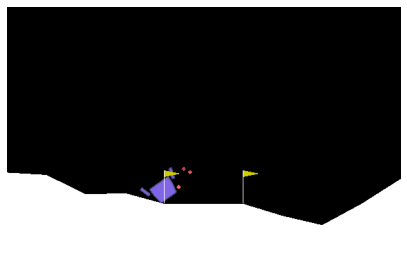

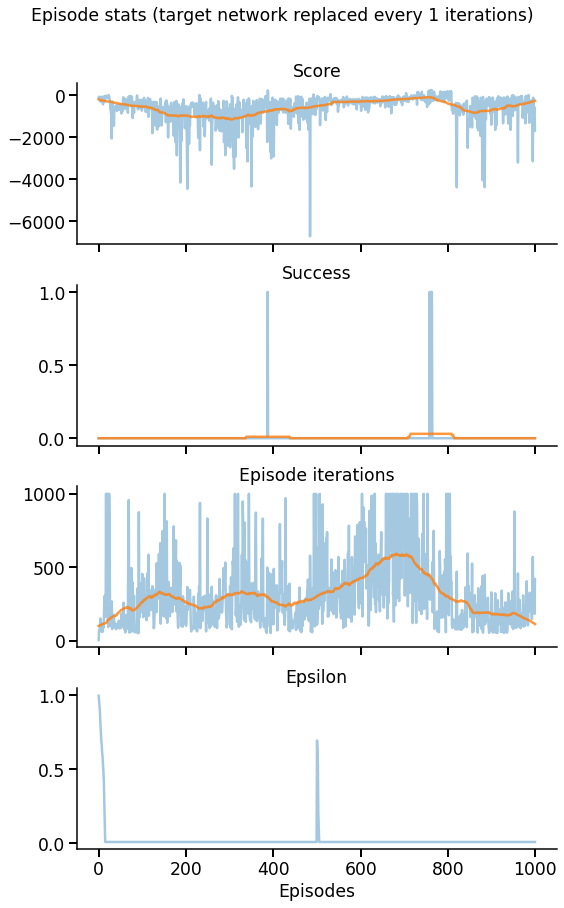

In [ ]:
N_EPISODES = 1000
REPLACE_TARGET = 1
SEED = 3412

scores, avg_scores, eps_history, iters, successes = run_episodes(
    N_EPISODES, REPLACE_TARGET, verbose=False, seed=SEED)
plot_learning(N_EPISODES, scores, eps_history, iters, successes, REPLACE_TARGET)

In [ ]:
N_EPISODES = 1000
REPLACE_TARGET = 40
SEED = 3412

scores, avg_scores, eps_history, iters, successes = run_episodes(
    N_EPISODES, REPLACE_TARGET, verbose=False, seed=SEED)
plot_learning(N_EPISODES, scores, eps_history, iters, successes, REPLACE_TARGET)

Preset seed: 3412
episode:    0    score: -121.6306    avg: -121.6306    iters:      4 (+4)        epsilon: 0.9980     success: False
episode:   50    score: -531.7570    avg: -149.0284    iters:  10965 (+104)      epsilon: 0.0100     success: False
episode:  100    score:  -74.5474    avg: -144.1560    iters:  32256 (+123)      epsilon: 0.0100     success: False
episode:  150    score:  278.8942    avg:  -43.6220    iters:  53397 (+384)      epsilon: 0.0100     success: True
episode:  200    score:    4.1844    avg:   24.0623    iters:  73076 (+125)      epsilon: 0.0100     success: False
episode:  250    score:  251.1927    avg:   50.2643    iters:  91752 (+628)      epsilon: 0.0100     success: True
